In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


This cell contains the objective functions, gradients, and Hessians.
You can swap between **Rosenbrock** and **Rastrigin** easily.

In [2]:
# ----------------------
# Rosenbrock Function
# ----------------------
def rosenbrock(x):
    return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1-x[0]) - 400*x[0]*(x[1]-x[0]**2)
    dy = 200*(x[1]-x[0]**2)
    return np.array([dx, dy])

def rosenbrock_hessian(x):
    x1, x2 = x[0], x[1]
    h11 = 2 - 400*(x2 - 3*x1**2)
    h12 = -400*x1
    h21 = h12
    h22 = 200
    return np.array([[h11, h12],[h21, h22]])

# ----------------------
# Rastrigin Function
# ----------------------
def rastrigin(x):
    return 20 + (x[0]**2 - 10*np.cos(2*np.pi*x[0])) + (x[1]**2 - 10*np.cos(2*np.pi*x[1]))

def rastrigin_grad(x):
    dx = 2*x[0] + 20*np.pi*np.sin(2*np.pi*x[0])
    dy = 2*x[1] + 20*np.pi*np.sin(2*np.pi*x[1])
    return np.array([dx, dy])

def rastrigin_hessian(x):
    h11 = 2 + 40*np.pi**2*np.cos(2*np.pi*x[0])
    h22 = 2 + 40*np.pi**2*np.cos(2*np.pi*x[1])
    return np.array([[h11,0],[0,h22]])


## Gradient Descent and Refined Search

In [3]:
def gradient_descent(func, grad, x0, lr=0.001, momentum=0.0, max_iters=5000, tol=1e-6):
    x = x0.copy()
    v = np.zeros_like(x)
    history = []
    for i in range(max_iters):
        g = grad(x)
        v = momentum*v - lr*g
        x_new = x + v
        history.append(func(x_new))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, func(x), i+1, history

def gd_grid_search(func, grad, x0, learning_rates, momentums):
    results = []
    best_result = {"params": None, "final_value": float("inf"), "iterations": None, "history": None}
    for lr, mom in itertools.product(learning_rates, momentums):
        x_opt, f_val, iters, history = gradient_descent(func, grad, x0, lr, mom)
        results.append((lr, mom, f_val, iters, history))
        if f_val < best_result["final_value"]:
            best_result.update({"params": (lr,mom), "final_value": f_val, "iterations": iters, "history": history})
    return results, best_result

def gd_refined_search(func, grad, x0, best_lr, best_mom, lr_factors=[0.8,1.0,1.2,1.4], mom_offsets=[-0.03,0.0,0.03]):
    fine_learning_rates = [best_lr * f for f in lr_factors]
    fine_momentums = [round(best_mom + offset, 3) for offset in mom_offsets]

    fine_results = []
    best_fine = {"params": None, "final_value": float("inf"), "iterations": None, "history": None}
    for lr, mom in itertools.product(fine_learning_rates, fine_momentums):
        x_opt, f_val, iters, history = gradient_descent(func, grad, x0, lr, mom)
        fine_results.append((lr, mom, f_val, iters, history))
        if f_val < best_fine["final_value"]:
            best_fine.update({"params": (lr,mom), "final_value": f_val, "iterations": iters, "history": history})
    return fine_results, best_fine


## Newton's Method

In [4]:
def newton_method(func, grad, hess, x0, step_size=1.0, max_iters=1000, tol=1e-6):
    x = x0.copy()
    history = []
    for i in range(max_iters):
        g = grad(x)
        H = hess(x)
        try:
            p = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            break
        x_new = x + step_size*p
        history.append(func(x_new))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, func(x), i+1, history

def newton_grid_search(func, grad, hess, starting_points, step_sizes):
    results = []
    for x0_try, step in itertools.product(starting_points, step_sizes):
        x_opt, f_val, iters, history = newton_method(func, grad, hess, x0_try, step)
        results.append((x0_try, step, x_opt, f_val, iters, history))
    best = min(results, key=lambda x: x[3])
    return results, best


### Plotting helper

In [5]:
def plot_histories(results, best_history, title="Convergence"):
    plt.figure(figsize=(10,6))
    for item in results:
        history = item[-1]  # last element is history
        plt.plot(history, linestyle="--", alpha=0.6)
    plt.plot(best_history, color="black", linewidth=3, label="Best Run")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Function Value (log scale)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
def run_experiment(func, grad, hess, x0, starting_points, learning_rates, momentums, step_sizes):
    global gd_results, gd_best, fine_results, gd_best_refined, newton_results, newton_best

    # -------------------------------
    # Coarse Gradient Descent
    # -------------------------------
    gd_results, gd_best = gd_grid_search(func, grad, x0, learning_rates, momentums)
    
    # Filter only converged runs (f_val not NaN/Inf)
    converged_results = [r for r in gd_results if not np.isnan(r[2]) and not np.isinf(r[2])]

    # Coarse GD Table
    print("=== Coarse Gradient Descent Results (Converged Only) ===")
    print("{:<10} {:<10} {:<15} {:<10}".format("lr", "mom", "Final f(x)", "Iterations"))
    print("-"*50)
    for lr, mom, f_val, iters, _ in converged_results:
        print("{:<10} {:<10} {:<15.6e} {:<10}".format(lr, mom, f_val, iters))

    # Print best coarse combo
    print("\n>>> Best Coarse GD Run:")
    print(f" Learning Rate: {gd_best['params'][0]}")
    print(f" Momentum: {gd_best['params'][1]}")
    print(f" Final f(x): {gd_best['final_value']:.6e}")
    print(f" Iterations: {gd_best['iterations']}")

    # Coarse GD Plot
    plt.figure(figsize=(10,6))
    for lr, mom, f_val, _, history in converged_results:
        if f_val < 10.0:  # only plot runs that actually got close
            clipped_history = np.clip(history, 1e-8, 100)
            plt.plot(clipped_history, linestyle="--", alpha=0.6, label=f"lr={lr}, mom={mom}")

    plt.plot(gd_best["history"], color="black", linewidth=3, label="Best Coarse Run")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Function Value (log scale)")
    plt.title("Coarse Grid Search: Gradient Descent (Converged Only)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Refined Gradient Descent
    # -------------------------------
    fine_results, gd_best_refined = gd_refined_search(func, grad, x0, gd_best["params"][0], gd_best["params"][1])

    # Refined GD Table
    print("\n=== Refined Gradient Descent Results ===")
    print("{:<10} {:<10} {:<15} {:<10}".format("lr", "mom", "Final f(x)", "Iterations"))
    print("-"*50)
    for lr, mom, f_val, iters, _ in fine_results:
        print("{:<10} {:<10} {:<15.6e} {:<10}".format(lr, mom, f_val, iters))

    # Print best refined combo
    print("\n>>> Best Refined GD Run:")
    print(f" Learning Rate: {gd_best_refined['params'][0]}")
    print(f" Momentum: {gd_best_refined['params'][1]}")
    print(f" Final f(x): {gd_best_refined['final_value']:.6e}")
    print(f" Iterations: {gd_best_refined['iterations']}")

    # Refined GD Plot
    plt.figure(figsize=(10,6))
    for lr, mom, _, _, history in fine_results:
        plt.plot(history, linestyle="--", alpha=0.6, label=f"lr={lr}, mom={mom}")
    plt.plot(gd_best_refined["history"], color="black", linewidth=3, label="Best Refined Run")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Function Value (log scale)")
    plt.title("Refined Grid Search: Gradient Descent")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Newton's Method
    # -------------------------------
    newton_results, newton_best = newton_grid_search(func, grad, hess, starting_points, step_sizes)

    # Newton Table
    print("\n=== Newton Method Results ===")
    print("{:<25} {:<10} {:<15} {:<10}".format("Starting x0", "Step", "Final f(x)", "Iterations"))
    print("-"*65)
    for x0_try, step, _, f_val, iters, _ in newton_results:
        print("{:<25} {:<10} {:<15.6e} {:<10}".format(str(x0_try), step, f_val, iters))

    # Print best Newton combo
    print("\n>>> Best Newton Run:")
    print(f" Initial x0: {newton_best[0]}")
    print(f" Step size: {newton_best[1]}")
    print(f" Final f(x): {newton_best[3]:.6e}")
    print(f" Iterations: {newton_best[4]}")

    # Newton Plot
    plt.figure(figsize=(10,6))
    for x0_try, step, _, _, _, history in newton_results:
        plt.plot(history, linestyle="--", alpha=0.6, label=f"x0={x0_try}, step={step}")
    plt.plot(newton_best[5], color="red", linewidth=3, label="Best Newton Run")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Function Value (log scale)")
    plt.title("Newton Method Grid Search")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Final Comparison Plot
    # -------------------------------
    plt.figure(figsize=(10,6))
    plt.plot(gd_best_refined["history"], color="blue", linewidth=3, 
             label=f"Best Refined GD\nlr={gd_best_refined['params'][0]}, mom={gd_best_refined['params'][1]}")
    plt.plot(newton_best[5], color="red", linewidth=3, 
             label=f"Best Newton\nx0={newton_best[0]}, step={newton_best[1]}")
    plt.yscale("log"); plt.xlabel("Iteration"); plt.ylabel("Function Value (log scale)")
    plt.title("Comparison: Best Refined GD vs Best Newton")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Coarse Gradient Descent Results (Converged Only) ===
lr         mom        Final f(x)      Iterations
--------------------------------------------------
0.0001     0.0        4.974790e+00    332       
0.0001     0.5        4.974790e+00    167       
0.0001     0.9        4.974791e+00    183       
0.001      0.0        4.974790e+00    36        
0.001      0.5        4.974790e+00    41        
0.001      0.9        4.974790e+00    181       
0.01       0.0        4.068107e+01    5000      
0.01       0.5        1.945905e+01    5000      
0.01       0.9        5.569644e+01    5000      
0.1        0.0        3.791113e+01    5000      
0.1        0.5        5.908400e+02    5000      
0.1        0.9        2.819786e+03    5000      

>>> Best Coarse GD Run:
 Learning Rate: 0.001
 Momentum: 0.0
 Final f(x): 4.974790e+00
 Iterations: 36


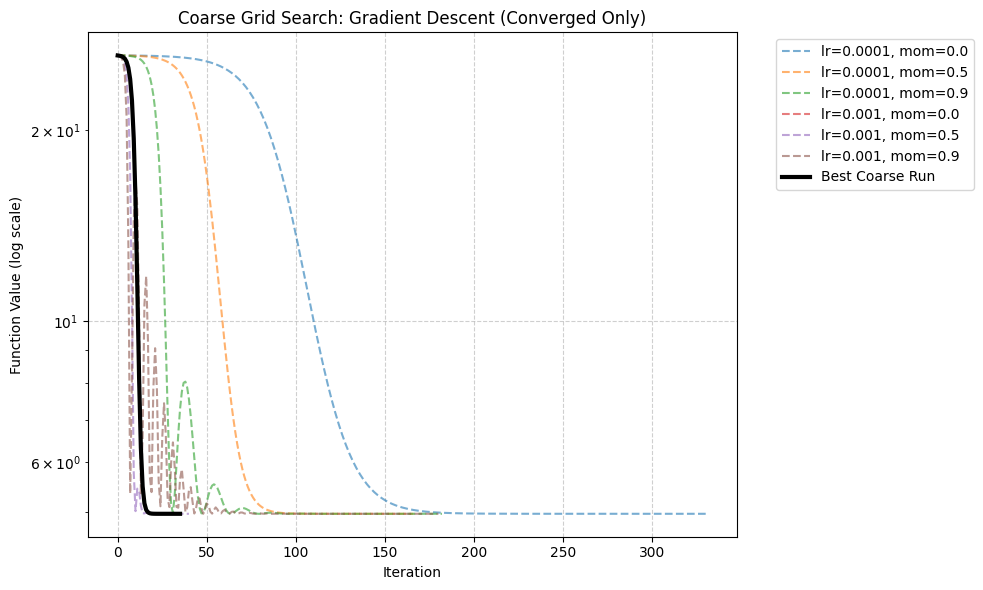


=== Refined Gradient Descent Results ===
lr         mom        Final f(x)      Iterations
--------------------------------------------------
0.0008     -0.03      4.974790e+00    47        
0.0008     0.0        4.974790e+00    45        
0.0008     0.03       4.974790e+00    44        
0.001      -0.03      4.974790e+00    38        
0.001      0.0        4.974790e+00    36        
0.001      0.03       4.974790e+00    35        
0.0012     -0.03      4.974790e+00    31        
0.0012     0.0        4.974790e+00    30        
0.0012     0.03       4.974790e+00    28        
0.0014     -0.03      4.974790e+00    27        
0.0014     0.0        4.974790e+00    25        
0.0014     0.03       4.974790e+00    24        

>>> Best Refined GD Run:
 Learning Rate: 0.0014
 Momentum: 0.03
 Final f(x): 4.974790e+00
 Iterations: 24


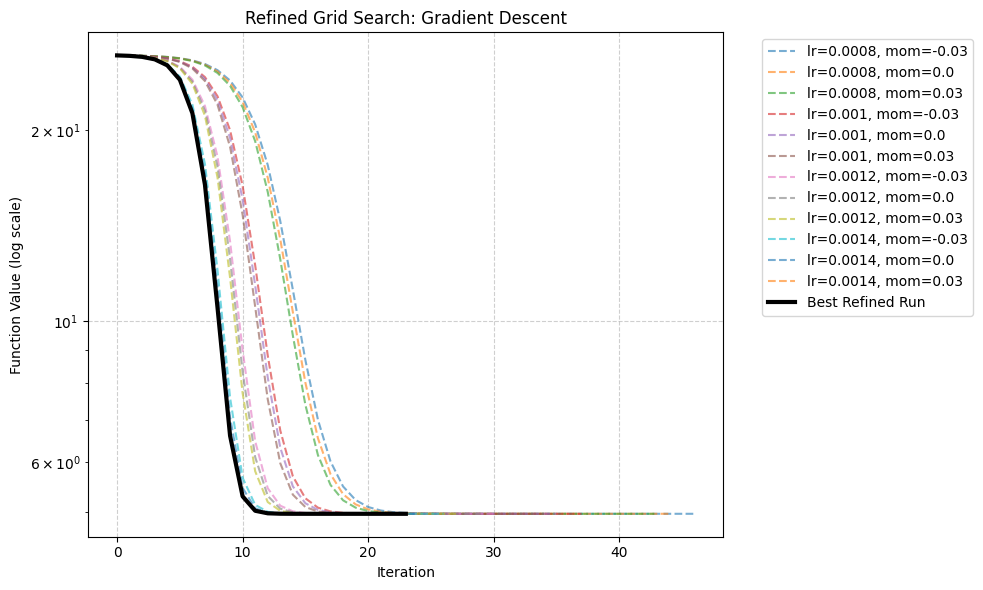


=== Newton Method Results ===
Starting x0               Step       Final f(x)      Iterations
-----------------------------------------------------------------
[-1.5  2. ]               0.1        2.624129e+01    69        
[-1.5  2. ]               0.5        2.624129e+01    14        
[-1.5  2. ]               1.0        2.624129e+01    3         
[-1.   1.5]               0.1        2.325642e+01    66        
[-1.   1.5]               0.5        2.325642e+01    14        
[-1.   1.5]               1.0        2.325642e+01    3         
[ 2. -1.]                 0.1        4.974790e+00    68        
[ 2. -1.]                 0.5        4.974790e+00    14        
[ 2. -1.]                 1.0        4.974790e+00    3         
[-2. -1.]                 0.1        4.974790e+00    68        
[-2. -1.]                 0.5        4.974790e+00    14        
[-2. -1.]                 1.0        4.974790e+00    3         

>>> Best Newton Run:
 Initial x0: [ 2. -1.]
 Step size: 1.0
 Final f(x

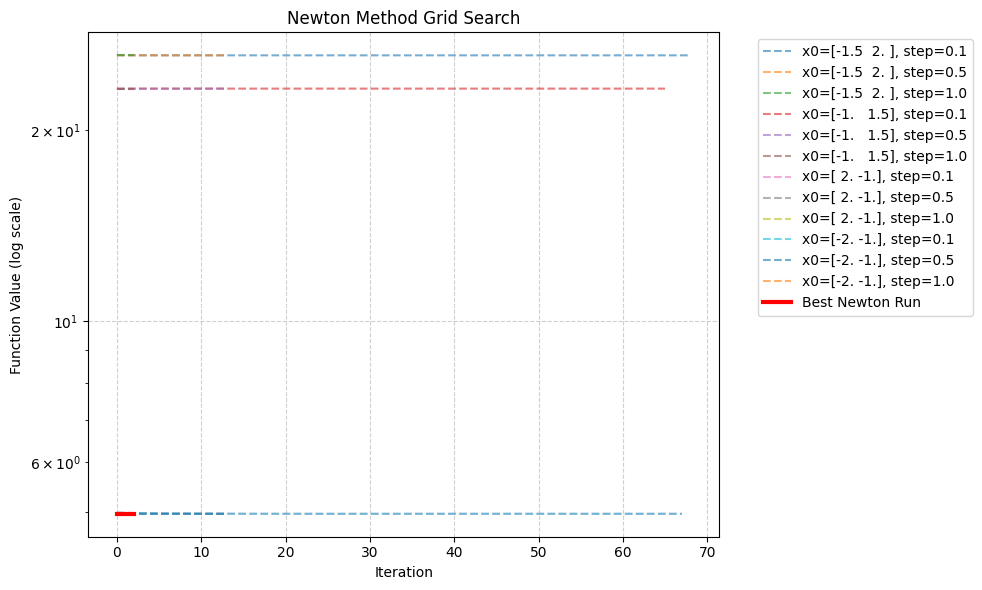

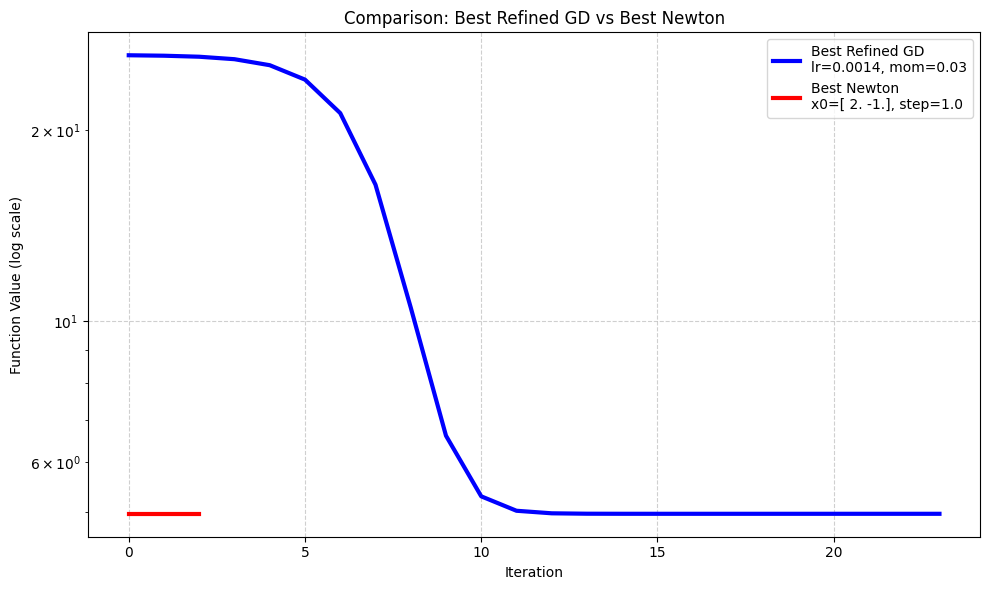

In [18]:
# === Swap function here to run Rosenbrock or Rastrigin ===
FUNC, GRAD, HESS = rastrigin, rastrigin_grad, rastrigin_hessian

X0 = np.array([-1.5, 2.0])
START_POINTS = [np.array([-1.5,2.0]), np.array([-1.0,1.5]), np.array([2.0,-1.0]), np.array([-2.0,-1.0])]
LEARNING_RATES = [1e-4, 1e-3, 1e-2, 1e-1]
MOMENTUMS = [0.0, 0.5, 0.9]
STEP_SIZES = [0.1, 0.5, 1.0]

run_experiment(FUNC, GRAD, HESS, X0, START_POINTS, LEARNING_RATES, MOMENTUMS, STEP_SIZES)


/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:5: RuntimeWarning: overflow encountered in scalar power
  return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2
/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:8: RuntimeWarning: overflow encountered in scalar power
  dx = -2*(1-x[0]) - 400*x[0]*(x[1]-x[0]**2)
/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:9: RuntimeWarning: overflow encountered in scalar power
  dy = 200*(x[1]-x[0]**2)
/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2
/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  dx = -2*(1-x[0]) - 400*x[0]*(x[1]-x[0]**2)
/var/folders/tw/djq1qjxx4_v0lvns6wbl3cxm0000gn/T/ipykernel_30649/2101756614.py:9: RuntimeWarning: inval

=== Coarse Gradient Descent Results (Converged Only) ===
lr         mom        Final f(x)      Iterations
--------------------------------------------------
0.0001     0.0        4.484731e+00    5000      
0.0001     0.5        2.781895e+00    5000      
0.0001     0.9        6.384125e-03    5000      
0.001      0.0        6.514365e-03    5000      
0.001      0.5        9.509502e-05    5000      
0.001      0.9        1.158889e-08    2020      

>>> Best Coarse GD Run:
 Learning Rate: 0.001
 Momentum: 0.9
 Final f(x): 1.158889e-08
 Iterations: 2020


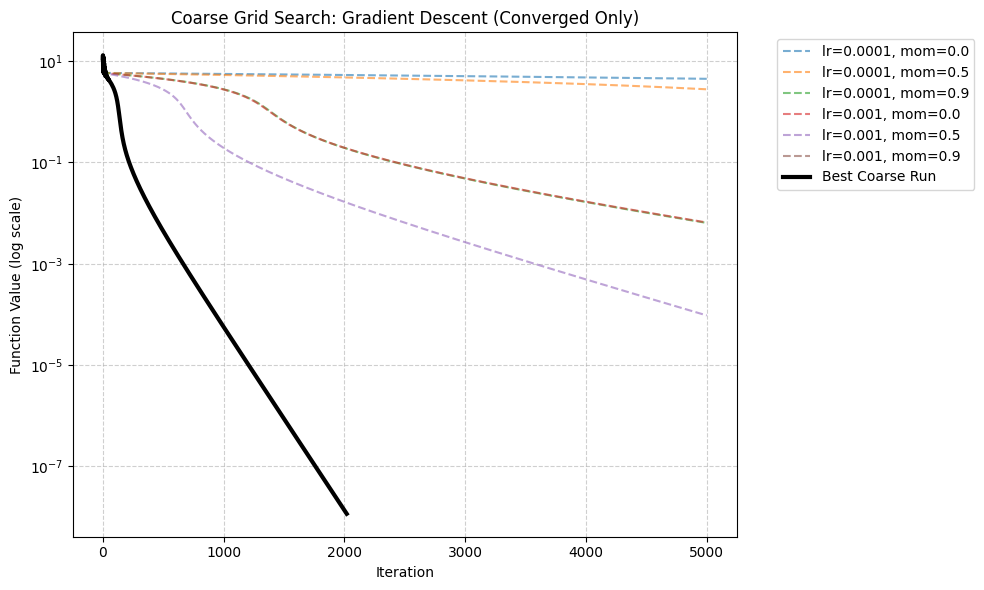


=== Refined Gradient Descent Results ===
lr         mom        Final f(x)      Iterations
--------------------------------------------------
0.0008     0.87       3.182981e-08    3179      
0.0008     0.9        1.835772e-08    2487      
0.0008     0.93       8.339831e-09    1735      
0.001      0.87       2.019908e-08    2598      
0.001      0.9        1.158889e-08    2020      
0.001      0.93       5.146919e-09    1382      
0.0012     0.87       1.394441e-08    2197      
0.0012     0.9        7.890926e-09    1698      
0.0012     0.93       3.429970e-09    1135      
0.0014     0.87       1.015498e-08    1894      
0.0014     0.9        5.686668e-09    1451      
0.0014     0.93       2.387590e-09    925       

>>> Best Refined GD Run:
 Learning Rate: 0.0014
 Momentum: 0.93
 Final f(x): 2.387590e-09
 Iterations: 925


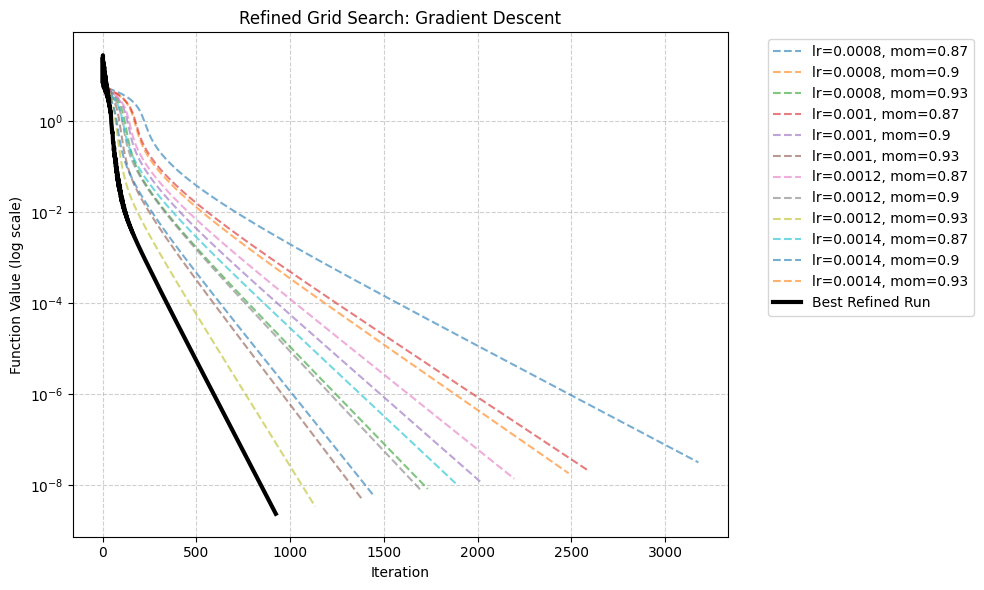


=== Newton Method Results ===
Starting x0               Step       Final f(x)      Iterations
-----------------------------------------------------------------
[-1.5  2. ]               0.1        1.680252e-11    203       
[-1.5  2. ]               0.5        4.894135e-13    48        
[-1.5  2. ]               1.0        1.195444e-12    7         
[-1.   1.5]               0.1        1.719373e-11    216       
[-1.   1.5]               0.5        4.002856e-13    52        
[-1.   1.5]               1.0        2.021378e-22    7         
[ 2. -1.]                 0.1        1.772655e-11    197       
[ 2. -1.]                 0.5        9.144068e-13    40        
[ 2. -1.]                 1.0        1.548386e-13    5         
[-2. -1.]                 0.1        1.721936e-11    240       
[-2. -1.]                 0.5        2.358502e-13    56        
[-2. -1.]                 1.0        3.081488e-27    6         

>>> Best Newton Run:
 Initial x0: [-2. -1.]
 Step size: 1.0
 Final f(x

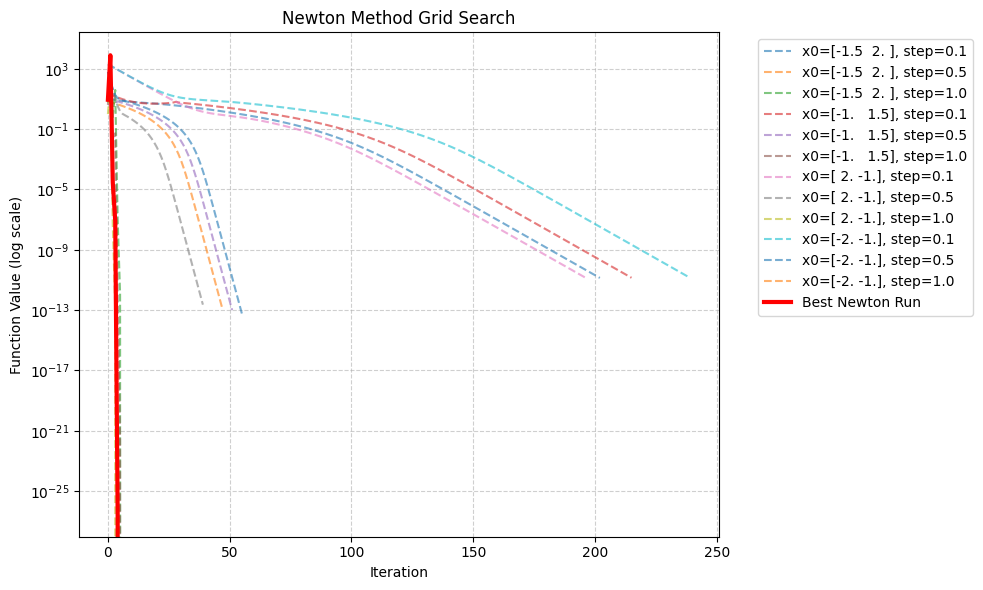

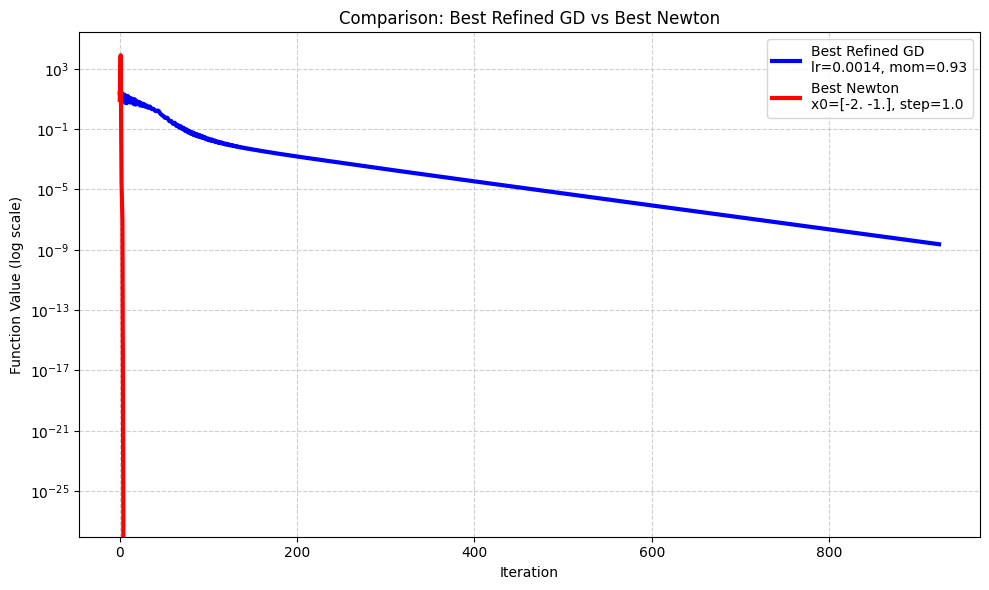

In [19]:
# === Swap function here to run Rosenbrock or Rastrigin ===
FUNC, GRAD, HESS = rosenbrock, rosenbrock_grad, rosenbrock_hessian

X0 = np.array([-1.5, 2.0])
START_POINTS = [np.array([-1.5,2.0]), np.array([-1.0,1.5]), np.array([2.0,-1.0]), np.array([-2.0,-1.0])]
LEARNING_RATES = [1e-4, 1e-3, 1e-2, 1e-1]
MOMENTUMS = [0.0, 0.5, 0.9]
STEP_SIZES = [0.1, 0.5, 1.0]

run_experiment(FUNC, GRAD, HESS, X0, START_POINTS, LEARNING_RATES, MOMENTUMS, STEP_SIZES)